In [1]:
# Import my code
#from tensorfactorization.poisson import *
from tensorfactorization.multiplicative import *

In [2]:
import tensorly as tl
import numpy as np
import math
import time
import random
import matplotlib.pyplot as plt
from skimage import data

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from dataclasses import dataclass, field
from typing import List

import copy # import copy so that we can do deep copys

import pickle # use pickle to save results to disk

In [89]:
def tensor_factorization_cp_poisson(X, F, error=1e-6, max_iter=500, detailed=False, verbose=False):
    """
    This function uses a multiplicative method to calculate a nonnegative tensor decomposition
    
    Args:
      X: The tensor of dimension N we want to decompose. X \in \RR^{I_1 x ... x I_N}
      F: The order of the apporximation
      error: stops iteration if difference between X and approximation with decomposition changes less then this
      max_iter: maximum number of iterations
      detailed: if false, function returns only G and the As. if true returns also all errors found during calculation 
      verbose: If True, prints additional information
    
    Returns:
      A list of tensors approximating X 
    """
    
    N = X.ndim # get dimension of X
    X_shape = X.shape
    norm_X = tl.norm(X)
    # initialize A_j with random positive values
    A_ns = []
    for i in range(N):
        # we use random.random_tensor as it returns a tensor
        A_ns.append(tl.random.random_tensor((X_shape[i], F), **tl.context(X)))
    
    # the reconstruction error
    approximated_X = defactorizing_CP(A_ns, X_shape)
        
    RE = [tl.norm(X-approximated_X)/norm_X]
    for _ in range(max_iter):
        for n in range(N):
            start = time.time()
            
            khatri_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
            approximated_X_unfolded_n = tl.matmul(A_ns[n], tl.transpose(khatri_rao_product)) # TODO consider if we want to use the same for all matrizes or update along the way
            
            # Step size calculation
            sigma = 0.5
            beta = 0.8
            alpha = 5.0
            m = 0 # TODO need to find some estimation for first m! otherwise need to compute too much
            step_size = math.pow(beta, m) * alpha
            f = lambda A: tl.sum( tl.matmul(A, tl.transpose(khatri_rao_product)) - tl.base.unfold(X, n) * tl.log( tl.matmul(A, tl.transpose(khatri_rao_product)) )) 
            function_value_at_iteration = tl.sum(approximated_X_unfolded_n - tl.base.unfold(X, n) * tl.log(approximated_X_unfolded_n)) 
            gradient_at_iteration = tl.matmul(tl.ones(approximated_X_unfolded_n.shape) - (tl.base.unfold(X, n) / approximated_X_unfolded_n) , khatri_rao_product )
            riemanndian_gradient_at_iteration = A_ns[n] * gradient_at_iteration # The "A_ns[n] *" is the inverse of the Riemannien metric tensor matrix thing
            norm_of_rg = tl.norm(riemanndian_gradient_at_iteration) ** 2 # TODO this has to use the Riemannian norm. Need to update formula for it!
            next_iterate =  A_ns[n] * tl.exp(-step_size * riemanndian_gradient_at_iteration)
            # TODO get rid of just using numpy for checking for infinity, to also make use of pytorch as well.
            while not np.isfinite(next_iterate).all() or ( function_value_at_iteration - sigma * step_size * norm_of_rg < f(next_iterate) ):
                m += 1
                step_size = math.pow(beta, m) * alpha
                next_iterate =  A_ns[n] * tl.exp(-step_size * gradient_at_iteration)

            A_ns[n] = next_iterate
            # OLD CODE, kept for safety
            # regular * does componentwise multiplication
            #A_ns[n] = A_ns[n] * tl.exp(-step_size * tl.matmul(tl.ones(approximated_X_unfolded_n.shape) - (tl.base.unfold(X, n) / approximated_X_unfolded_n) , khatri_rao_product )  ) 
            
            end = time.time()
            if verbose:
                print("Current index: " + str(n))
                print("Calculculation time: " + str(end - start))
                print("New objective function value: " + str(f(A_ns[n])))
                print("step size was: " + str(step_size) + " with m = " + str(m))

                print("function_value_at_iteration = " + str(function_value_at_iteration))
                print("norm_of_rg = " + str(norm_of_rg))
                print("gradiend_at_iteration = ")
                print(gradient_at_iteration)
                print("riemannian_gradient_at_iteration = ")
                print(riemanndian_gradient_at_iteration)

                print("new A_ns[n]:")
                print(A_ns[n])
                
                
            
        # the reconstruction error
        approximated_X = defactorizing_CP(A_ns, X_shape)
        RE.append(tl.norm(X-approximated_X)/norm_X)

        if verbose:
            print("current apporximation error is: " + str(RE[-1]))
            #print("approximation is:")
            #print(approximated_X)
        
        # check if we have converged
        if abs(RE[-1] - RE[-2]) < error:
            break

    # TODO I think we can skip this for now
    """
    # Rescale the A_ns
    # TODO there should be a smarter way of calculating K
    K = []
    for n in range(N):
        K_j = []
        for a in range(F):
            sum = 0
            for i in range(X_shape[n]):
                sum += A_ns[n][i, a]**2
            K_j.append(math.sqrt(sum))
        K.append(K_j)
    K = tl.tensor(K, **tl.context(X))
    for n in range(N):
        for a in range(F):
            A_ns[n][:, a] = A_ns[n][:, a] * math.pow(tl.prod(K[:, a]), 1.0/N) / K[n, a]
    """

    if detailed:
        return A_ns, RE, approximated_X
    return A_ns

Current index: 0
Calculculation time: 0.00099945068359375
New objective function value: 1302.140359811262
step size was: 0.03689348814741915 with m = 22
function_value_at_iteration = 1396.857715691211
norm_of_rg = 1438.4623650568246
gradiend_at_iteration = 
[[-1.57725877e+01 -3.02174224e+00]
 [-6.16223162e+00 -1.82736920e+00]
 [-2.33097597e+01 -9.43294291e+00]
 [-1.80465391e+00  2.08112542e-01]
 [-1.51449834e+00  6.63144193e-01]
 [ 2.13732097e+00  1.05134263e+00]
 [ 5.65082752e-01  1.38601121e+00]
 [-3.92673219e+01 -5.52832946e+00]
 [ 4.95197925e+00  1.43782849e+00]
 [-1.27823045e+01 -4.78527675e-01]
 [-1.34049807e+01 -2.98287336e+00]
 [-2.93381513e+01 -2.76312131e+00]
 [ 7.82063060e+00  2.49649072e+00]
 [ 1.17463796e+01  4.05205854e+00]
 [-6.01057404e+01 -8.33242880e+00]
 [-3.25890918e+00 -1.71627209e-01]
 [ 1.28941719e+01  4.37568324e+00]
 [-1.00300798e+02 -6.55346940e+00]
 [ 1.29096458e+01  4.73920497e+00]
 [ 7.90868816e+00  2.83702805e+00]
 [-3.56208494e-03 -3.95314964e-02]
 [-1.01

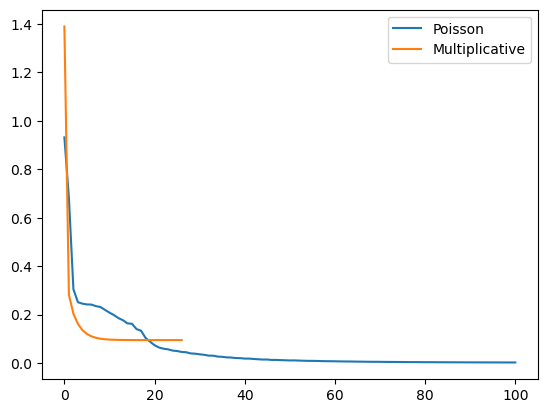

In [85]:
# TESTING WHAT THE PROBLEM IS WITH LARGE TENSORS
dimensions = (50, 10, 4)
F = 2
A = tl.random.random_cp(dimensions, F, full=True)
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson = tensor_factorization_cp_poisson(A, F, max_iter=100, detailed=True, verbose=True)
end = time.time()
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.legend()
plt.show()

Poisson algorithm took 0.4909985065460205 seconds with 107 iterations and had final error of 0.002472276089689375
Multiplicative algorithm took 0.13199996948242188 seconds with 751 iterations and had final error of 0.016341971432563156


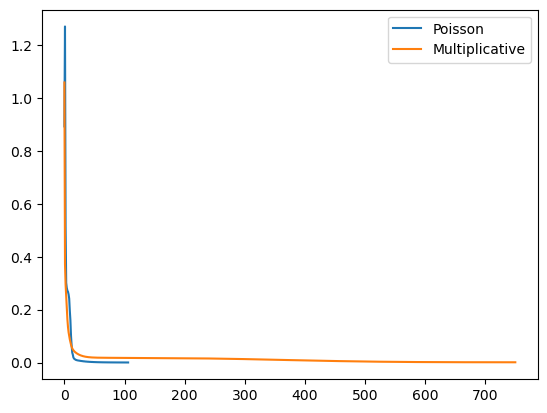

In [90]:
dimensions = (30, 30, 4)
F = 2
A = tl.random.random_cp(dimensions, F, full=True)
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson = tensor_factorization_cp_poisson(A, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(A, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(A - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(A - approx_mult)))
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.legend()
plt.show()

In [32]:
tl.exp(666*1)

1.7383008701505047e+289